<a href="https://colab.research.google.com/github/sidagarwal-labs/DSBA-6211---Advance-Business-Analytics/blob/main/ARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#create ARIMA model
import pandas as pd
df = pd.read_csv('Tractor-Sales.csv')
df.describe(include='all')

,Date,Sales
count,144,144.000000
unique,144,NaN
top,1/1/2003,NaN
freq,1,NaN
mean,NaN,389.694444
std,NaN,171.500016
min,NaN,138.000000
25%,NaN,248.500000
50%,NaN,369.000000
75%,NaN,509.250000


In [ ]:
#info about the database
#date is currently an object data type - need to fix
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    144 non-null    object
 1   Sales   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
#fix data data type
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

In [ ]:
#generate timeseries data
sales_ts = pd.Series(df.Sales.values,
                     index=df.Date,
                     name='Sales')

In [ ]:
#inspect time series data - double check
sales_ts

,Sales
Date,
2003-01-01,141
2003-02-01,157
2003-03-01,185
2003-04-01,199
2003-05-01,203
...,...
2014-08-01,848
2014-09-01,640
2014-10-01,581


<Axes: xlabel='Time', ylabel='Sales'>

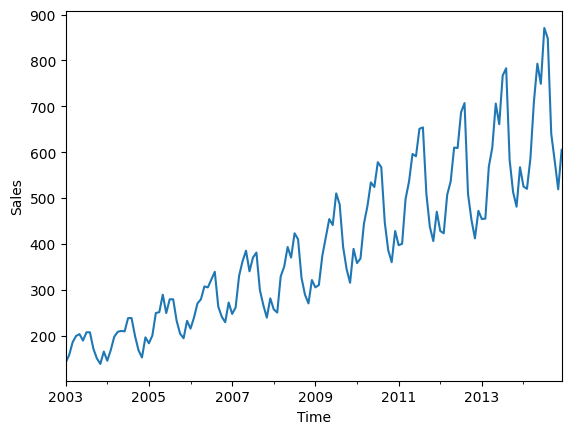

In [ ]:
#visualize the entire timeseries for intial inspection
#mean is not constant, variance is not constant
#non stationary
import matplotlib.pyplot as plt
ax = sales_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
ax

In [ ]:
#run a test to see if this is not stationary
#if p value is not significant, it is not stationary
#highly insignificant at 0.995, not stationary
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4],index=['Test Statistics',
                                        'p-value',
                                        '#lags used',
                                        'Number of Observations used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistics                  1.108825
p-value                          0.995291
#lags used                      14.000000
Number of Observations used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [ ]:
#Log transformation to achieve constant variance
import numpy as np
sales_ts_log = np.log10(sales_ts)

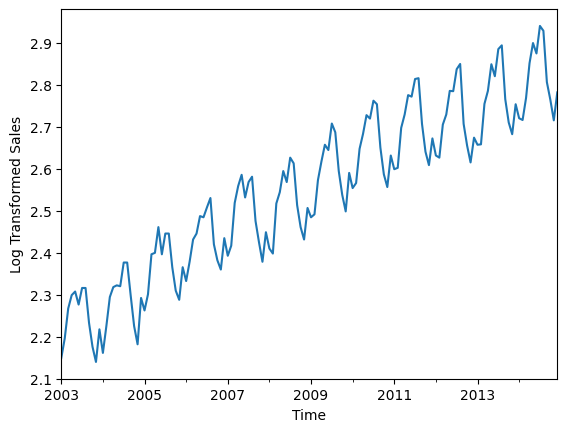

In [ ]:
ax = sales_ts_log.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Log Transformed Sales')
plt.show()

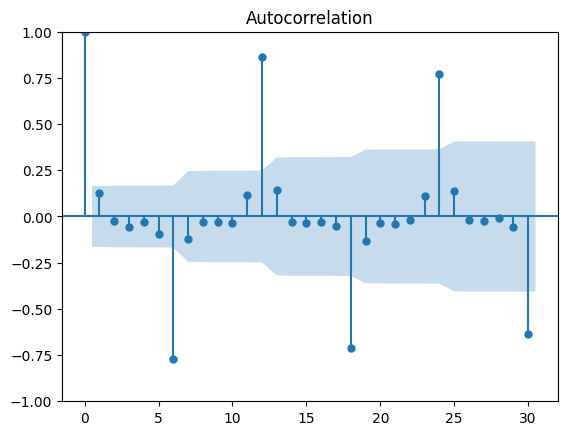

In [ ]:
# Plot ACF to check potential seasonality
# ACF: autocorrelation factor
import statsmodels.tsa.api as smt
sales_ts_log_diff = sales_ts_log.diff(periods=1)
sales_ts_log_diff.dropna(inplace=True)
smt.graphics.plot_acf(sales_ts_log_diff,
lags=30,
alpha=0.05)
plt.show()

In [ ]:
#split data train and valid
nValid = 36
nTrain = len(sales_ts_log) - nValid

train_ts = sales_ts_log[:nTrain]
valid_ts = sales_ts_log[nTrain:]

In [ ]:
#generate pdq values
import itertools
p = d = q = range(0,2)

In [ ]:
pdq=list(itertools.product(p,d,q))

In [ ]:
seasonal_pdq=[(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

In [ ]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [ ]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [ ]:
#remove warnings
import sys
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#setup the intial values of pdq model
best_aic = np.info
best_pdq = None
best_seasonal_pdq = None
temp_model = None

import statsmodels.api as sm
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      temp_model = sm.tsa.statespace.SARIMAX(train_ts,
                                             order=param,
                                             seasonal_order=param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
      results = temp_model.fit()

      if results.aic < best_aic:
        best_aic = results.aic
        best_pdq = param
        best_seasonal_pdq = param_seasonal
    except:
        continue
print('Best SARIMAX {} x {} 12 model-AIC:{}'.format(best_pdq,best_seasonal_pdq,best_aic))

Best SARIMAX None x None 12 model-AIC:<function info at 0x79cf82c5fe20>


In [ ]:
best_model = sm.tsa.statespace.SARIMAX(train_ts,
                                       order=(0,1,1),
                                       season_order=(1,0,1,12),
                                       enforce_stationarity=True,
                                       enforce_invertibility=True)
best_results = best_model.fit()

In [ ]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  108
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 158.801
Date:                Tue, 11 Nov 2025   AIC                           -313.602
Time:                        01:03:22   BIC                           -308.256
Sample:                    01-01-2003   HQIC                          -311.435
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1251      0.121      1.037      0.300      -0.111       0.361
sigma2         0.0030      0.001      5.745      0.000       0.002       0.004


In [ ]:
pred = best_results.get_forecast(steps=36, alpha=0.05)

In [ ]:
!pip install dmba
from dmba import regressionSummary
regressionSummary(np.power(10,valid_ts),
np.power(10,pred.predicted_mean))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 40.4 MB/s eta 0:00:00
Colab environment detected.

Regression statistics

                      Mean Error (ME) : 116.6539
       Root Mean Squared Error (RMSE) : 169.4898
            Mean Absolute Error (MAE) : 130.9798
          Mean Percentage Error (MPE) : 16.2101
Mean Absolute Percentage Error (MAPE) : 19.5351
